# Milestone 3
This notebook should be connected with milestone 2 at one point, but easier to work with two different notebooks.

In [94]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns; sns.set()
from matplotlib.font_manager import FontProperties

In [95]:
from imp import reload
import scripts.visualization
reload(scripts.visualization)
from scripts.visualization import *

## Question 1 - How has the crops and livestock production changed since the 1960s?
To get a general picture of how production has changed we start by looking at everything at a world-level.

This question will serve as an intro to the whole project and look at the big trends in the world, with focus on products more than areas. We will mainly study total development of production (without normalizing for population), as this is how the production actually has developed and how the scale has changed during the 50 years.
We will follow these steps:

- Get an overview of development by analyzing at world-level.
- Look if any special products have increased/decreased in popularity.
- Find statistical indicators showing the differences now and in 1960.
- Look for certain countries and areas that stand out.

In [96]:
# Load data
data_path = 'data/pickles/'
meat_cont = pd.read_pickle(data_path + 'meat_categorized.pkl')
crops_cont = pd.read_pickle(data_path + 'crops_categorized.pkl')
pop_cont = pd.read_pickle(data_path + 'pop_continents.pkl')

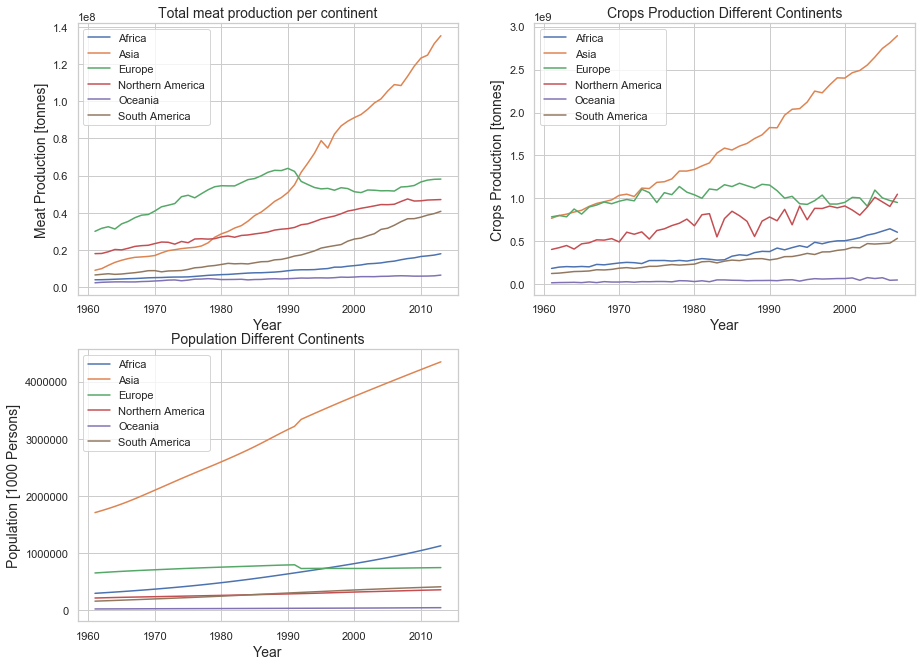

In [97]:
# Plot of how meat production, crops production and population have developed since 1961

fig = plt.figure(figsize = (15, 11))
meat_total = meat_cont[meat_cont.Item == 'Meat, Total']
meat_no_total = meat_cont[np.logical_not(meat_cont['Item'] == 'Meat, Total')]
crops_total = crops_cont[crops_cont.Item == 'Crops, total']
crops_no_total = crops_cont[np.logical_not(crops_cont.Item.str.contains('total'))]

ax1 = plt.subplot(2,2,1)
plot_compare_areas(meat_total, 
                   y = 'Value', y_label = 'Meat Production [tonnes]',
                   title='Total meat production per continent',
                   subplot = True, ax = ax1)

ax2 = plt.subplot(2,2,2)
plot_compare_areas(crops_total, 
                    y = 'Value', y_label = 'Crops Production [tonnes]',
                    title='Crops Production Different Continents',
                    subplot = True, ax = ax2)

ax3 = plt.subplot(2,2,3)
plot_compare_areas(pop_cont, 
                    y = 'Value', y_label = 'Population [1000 Persons]',
                    title='Population Different Continents',
                    subplot = True, ax = ax3)

We saw these plots earlier already in milestone 2. However, they nicely show how crops production, meat production and the population has risen globally since 1961. We can also see that the way that the production has developped follows a general pattern, that is, the population growth in each respective continent. This makes sense as an increased population will require more food production in order to be able to feed all habitants. 

In the population growth plot, there is a non-linear change in the population growth for both Europe and Asia in 1991. This is due to the fall of the Soviet Union in 1991 which resulted in new continent borders for Europe and Asia.

The drop in the meat production in Asia in 1997 is probably due to the asian financial crisis. The only meat production category that also drops this year is pig and when doing som research on Google, some results show that the asian financial crisis in 1997 affected the pig production. ([article 1](https://books.google.ch/books?id=DQUFd2UBUAwC&pg=PA5&lpg=PA5&dq=1995+asia+pig+production&source=bl&ots=8U_-qWYyqa&sig=ACfU3U3nubnDJojZckPCrny5KO-q0PjHuA&hl=en&sa=X&ved=2ahUKEwizv4Pr9rzmAhURsXEKHfYaCLUQ6AEwAXoECAoQAQ#v=onepage&q=asian%20financial%20crisis&f=false), [article 2](https://books.google.ch/books?id=eXtZwpHL5AcC&pg=RA1-PA2&lpg=RA1-PA2&dq=asian+financial+crisis+pig+production+1997&source=bl&ots=8Q74PJcET8&sig=ACfU3U249goE42MgSw9ODL2r8eNHVBcQQg&hl=en&sa=X&ved=2ahUKEwjE7MqG-rzmAhXj0aYKHY6fA20Q6AEwFnoECAsQAQ#v=onepage&q=asian%20financial%20crisis%20pig%20production%201997&f=false))

The crops production is in general quite volatile which is not surprising as crops production is very weather dependent which can lead to good and bad harvest years.

### Percentage increase of crops & meat production and population

Now we look at exactly how much the crops & meat production and population has increased since 1961 for each continent and for the world. 

In [98]:
# Adding world data to dataframes that are being studied

meat_total_world = meat_total.groupby('Year').agg({'Area':'first', 'Element':'first', 'Value':'sum', 'Unit':'first', 'Item':'first'}).reset_index()
meat_total_world.Area = 'World'
meat_total_all = pd.concat([meat_total_world, meat_total], axis=0)

crops_total_world = crops_total.groupby('Year').agg({'Area':'first', 'Element':'first', 'Value':'sum', 'Unit':'first', 'Item':'first'}).reset_index()
crops_total_world.Area = 'World'
crops_total_all = pd.concat([crops_total_world, crops_total], axis=0)

pop_total_world = pop_cont.groupby('Year').agg({'Area Code':'first', 'Area':'first', 'Unit':'first', 'Value':'sum'}).reset_index()
pop_total_world.Area = 'World'
pop_total_all = pd.concat([pop_total_world, pop_cont], axis=0)

In [99]:
# Comparing areawise total production of meat in raw numbers
meat_1961 = meat_total_all[meat_total_all['Year'] == 1961]
meat_2007 = meat_total_all[meat_total_all['Year'] == 2007]

comparison_m = pd.DataFrame({'Area':meat_1961.Area.unique(), 
                          '1961 total [tonnes]':meat_1961.Value.values, 
                          '2007 total [tonnes]':meat_2007.Value.values})
comparison_m['% Increase'] = round(comparison_m['2007 total [tonnes]']/comparison_m['1961 total [tonnes]']*100-100,2)
comparison_m = comparison_m.sort_values(by = 'Area')
print("Total meat production comparison for years 1961 and 2007 and each continent:\n", comparison_m)

# Comparing areawise total production of crops in raw numbers
crops_1961 = crops_total_all[crops_total_all['Year'] == 1961]
crops_2007 = crops_total_all[crops_total_all['Year'] == 2007]

comparison_c = pd.DataFrame({'Area':meat_1961.Area.unique(), 
                          '1961 total [tonnes]':crops_1961.Value.values, 
                          '2007 total [tonnes]':crops_2007.Value.values})
comparison_c['% Increase'] = round(comparison_c['2007 total [tonnes]']/comparison_c['1961 total [tonnes]']*100-100,2)
comparison_c = comparison_c.sort_values(by = 'Area')
print("\nTotal crops production comparison for years 1961 and 2007 and each continent:\n", comparison_c)

# Comparing areawise total population growth in raw numbers
population_1961 = pop_total_all[pop_total_all['Year'] == 1961]
population_2007 = pop_total_all[pop_total_all['Year'] == 2007]

comparison_p = pd.DataFrame({'Area':population_1961.Area.unique(), 
                          '1961 total [tonnes]':population_1961.Value.values, 
                          '2007 total [tonnes]':population_2007.Value.values})
comparison_p['% Increase'] = round(comparison_p['2007 total [tonnes]']/comparison_p['1961 total [tonnes]']*100-100,2)
comparison_p = comparison_p.sort_values(by = 'Area')
print("\nTotal population comparison for years 1961 and 2007 and each continent:\n", comparison_p)

Total meat production comparison for years 1961 and 2007 and each continent:
                Area  1961 total [tonnes]  2007 total [tonnes]  % Increase
1            Africa            3910553.0           14699140.0      275.88
2              Asia            9046039.0          108466131.0     1099.05
3            Europe           30004080.0           53861619.0       79.51
4  Northern America           17992024.0           46055112.0      155.98
5           Oceania            2298457.0            6083622.0      164.68
6     South America            6517115.0           35185524.0      439.89
0             World           69768268.0          264351148.0      278.90

Total crops production comparison for years 1961 and 2007 and each continent:
                Area  1961 total [tonnes]  2007 total [tonnes]  % Increase
1            Africa         1.851338e+08         6.063324e+08      227.51
2              Asia         7.687699e+08         2.894075e+09      276.46
3            Europe         

As could be seen in the plots in the previous section, all continents have seen an increase in crops and meat production. In fact, the production in all continents has has more than doubled except for Europe. Overall, there has been an immense increase in production of crops and the World production has almost tripled fro crops. Incredibly, meat production has risen by over 1000% in Asia. Overall, the global meat production has almost quadrupled. 

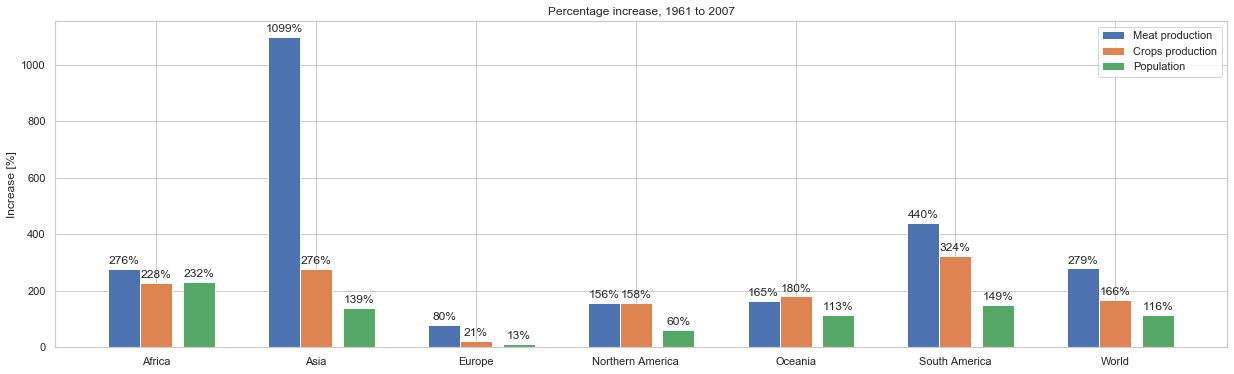

In [119]:
# Results from previous cell visualized
labels = comparison_p.Area.sort_values().unique()

x = np.arange(len(labels))+10  # the label locations
width = 0.2 # the width of the bars

fig, ax = plt.subplots(figsize=(21,6))
rects1 = ax.bar(x - width, round(comparison_m['% Increase']), width, label='Meat production')
rects2 = ax.bar(x, round(comparison_c['% Increase']), width, label='Crops production')
rects3 = ax.bar(x + width + width/3, round(comparison_p['% Increase']), width, label='Population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Increase [%]')
ax.set_title('Percentage increase, 1961 to 2007')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(str(height)+'%'),
                    xy = (rect.get_x() + rect.get_width() / 2, height),
                    xytext = (0, 3),  # 3 points vertical offset
                    textcoords = "offset points",
                    ha = 'center', va = 'bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.savefig('plots/Increase-meat-crop-pop.png')

Here we can see that the increase in food production (since 1961) is more than the increase in population. This means that we are producing more food per person today compared to 1961.

All continents but North America and Oceania have a larger increase in meat producation than both crops production and population growth. As mentioned before, Asia has more than 10-doubled its meat production.

### Comparison of the yearly increases of different meat and crop production

Text(0.5, 1.0, 'Mean yearly (%) increase of different crops')

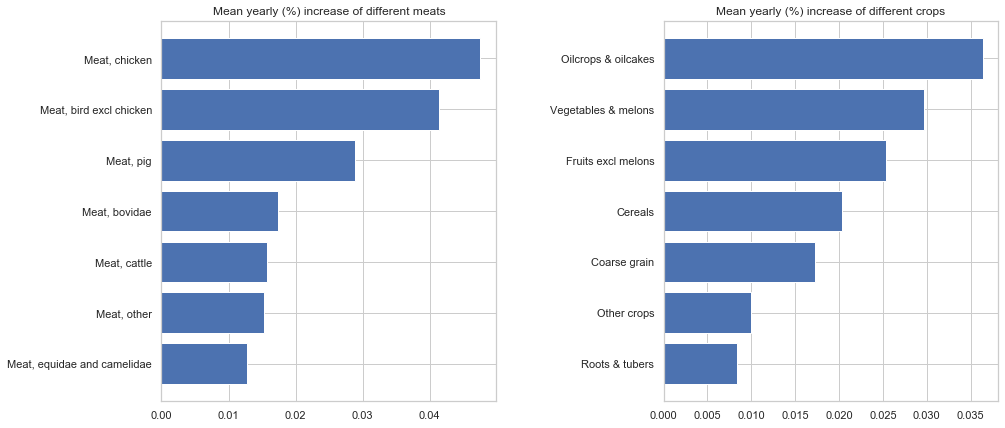

In [101]:
fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(15,7)
fig.subplots_adjust(wspace = 0.5)

# Create dataframe with mean yearly change in production of different meat products
mean_mproduct_growth = {}
for item in meat_no_total.Item.unique():
    mean_mproduct_growth.update({item: (meat_no_total[meat_no_total.Item == item].groupby('Year').sum().diff() 
                                        / meat_no_total[meat_no_total.Item == item].groupby('Year').sum()).Value.mean()})

mean_mproduct_growth = pd.DataFrame(mean_mproduct_growth.values(), mean_mproduct_growth.keys(), columns = ['Mean growth'])
mean_mproduct_growth.sort_values(by='Mean growth', inplace =True)

# Create dataframe with mean yearly change in production of different crops products
mean_cproduct_growth = {}
for item in crops_no_total.Item.unique():
    mean_cproduct_growth.update({item : (crops_no_total[crops_no_total.Item == item].groupby(['Year']).sum().diff()
                                        / crops_no_total[crops_no_total.Item == item].groupby(['Year']).sum()).Value.mean()})

mean_cproduct_growth = pd.DataFrame(mean_cproduct_growth.values(), mean_cproduct_growth.keys(), columns = ['Mean growth'])
mean_cproduct_growth.sort_values(by='Mean growth', inplace =True)

# Plot results
ax[0].barh(mean_mproduct_growth.index, mean_mproduct_growth['Mean growth'])
ax[0].set_title("Mean yearly (%) increase of different meats")

ax[1].barh(mean_cproduct_growth.index, mean_cproduct_growth['Mean growth'])
ax[1].set_title("Mean yearly (%) increase of different crops")

In the above plot we can see that different products have in fact experienced similar yearly increases in their production. Different kinds of poultry have experienced the largest year on year growth with chicken at nearly 5%. Poultry is very popular in Asia, thus it is no surprise that these have experienced such large growth. Interestingly the largest increase for crops have been oilcrops & oilcakes. Overall the year on year growth has been smaller for most crops compared to meat products. Cereals and coarse grain which are the two biggest crops categories have experienced moderate growth. 

### Comparison of the different production quantities for the different product categories and their variances

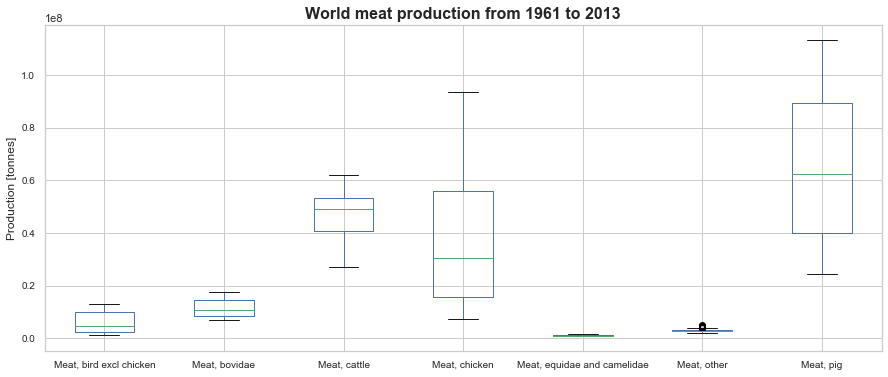

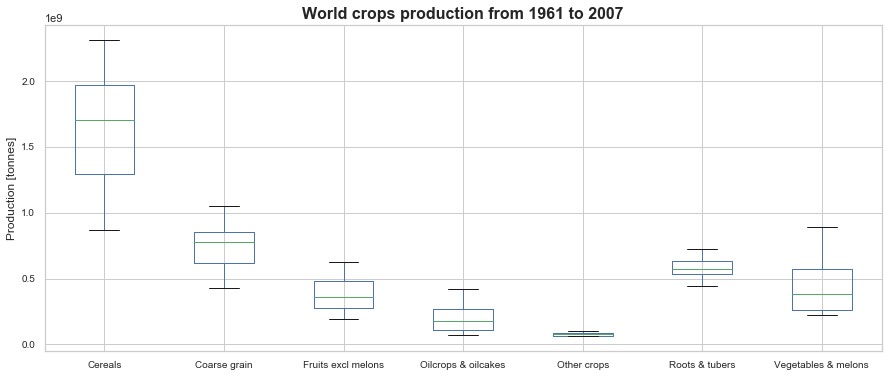

In [106]:
# Creat new dataframe for meat production where indexes are years and columns are the different meat categories
world_m = meat_no_total.groupby(['Year', 'Item']).agg({'Value':'sum'}).reset_index().sort_values(by=['Year', 'Item'], ascending=True)
meat_world = pd.DataFrame(columns=meat_no_total.Item.sort_values().unique(), 
             index=world_m.Year.unique(),
             data=world_m.Value.values.reshape(len(world_m.Year.unique()),len(meat_no_total.Item.unique())))

# Plot box plot of the different meat categories and how their production quantities have been over the years
ax = meat_world.plot(kind='box', figsize=(15,6))
ax.set_title('World meat production from 1961 to 2013', fontsize=16, fontweight='bold')
ax.set_ylabel('Production [tonnes]', fontsize=12)
ax.tick_params(labelsize=10)

# Creat new dataframe for crops production where indexes are years and columns are the different crops categories
world_c = crops_no_total.groupby(['Year', 'Item']).agg({'Value':'sum'}).reset_index().sort_values(by=['Year', 'Item'], ascending=True)
crops_world = pd.DataFrame(columns=crops_no_total.Item.sort_values().unique(), 
             index=world_c.Year.unique(),
             data=world_c.Value.values.reshape(len(world_c.Year.unique()),len(meat_no_total.Item.unique())))

# Plot box plot of the different crops categories and how their production quantities have been over the years
ax = crops_world.plot(kind='box', figsize=(15,6))
ax.set_title('World crops production from 1961 to 2007', fontsize=16, fontweight='bold')
ax.set_ylabel('Production [tonnes]', fontsize=12)
ax.tick_params(labelsize=10)

When it comes to meat production, we are producing mostly pig, chicken and cattle and pig production is the biggest. 
When it comes to crops production, we are producing mostly cereals which isn't surprising as rice and wheat are included in the cereals category. The production of 'meat, other', 'meat, equidae & camildae' and 'other crops' has been quite consistent since 1961 as their variance is very low compared to the others.

Let's visualize this in a line plot to make sure that the observations are correct.

In [ ]:
fig = plt.figure(figsize=(20,6)).subplots_adjust(wspace=0.7)
plot_compare_areas(world_m, grouping = 'Item', y = 'Value', y_label = 'Meat Production [tonnes]', 
                   title = 'Meat production: World', subplot = True, ax = plt.subplot(1, 2, 1), outside = True)
plot_compare_areas(world_c, grouping = 'Item', y = 'Value', y_label = 'Crops Production [tonnes]', 
                   title = 'Crops production: World', subplot = True, ax = plt.subplot(1, 2, 2), outside = True)

fig.savefig('plots/Food-growth.png')

What was observed in the box plot can also be observed in these plots. Pig is the biggest meat category and cereals is the biggest crops category. The production of 'meat, other', 'meat, equidae & camildae' and 'other crops' has been quite consistent since 1961.

### Food production development in each continent

Lets study the food production more in detail. What does to production look like for each continent?

#### Meat production

In [ ]:
plt.figure(figsize=(20,20)).subplots_adjust(wspace=0.7)
i = 0

for area in meat_cont.Area.unique():
    i+=1
    plot_compare_areas(meat_no_total[meat_no_total['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Meat Production [tonnes]', title = 'Meat production: '+area,
                    subplot = True, ax = plt.subplot(3, 2, i), outside = True)

**Continents that stand out:**
- Africa and Oceania are the only continents that have had a big increase in the meat category 'others'.
- In 2013 the three biggest meat categories are cattle, pig and chicken in all continents except Africa and Ocenia that have bovidae, cattle and chicken in top three. 

We wish to check what type of bovidae and other meats that Oceania and Africa produce a lot of.

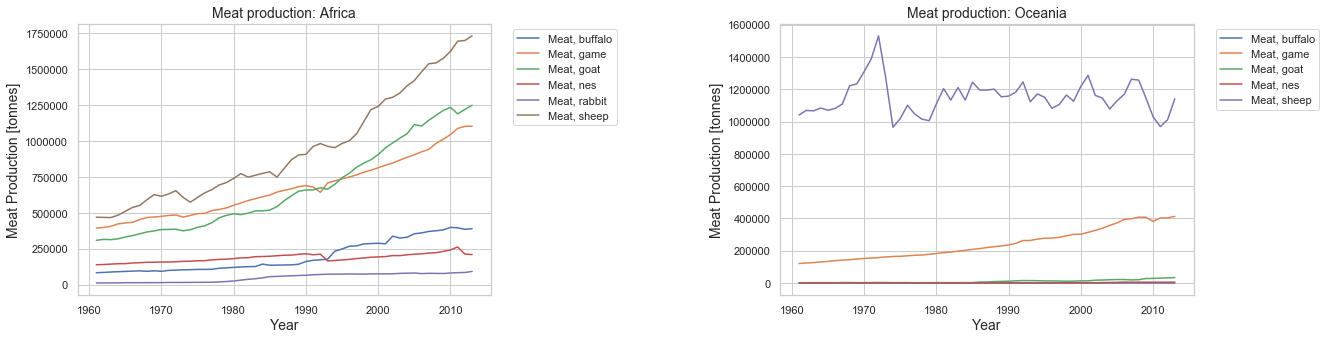

In [104]:
meat_uncategorized = pd.read_pickle(data_path + 'meat_continents.pkl')

interesting = ['Meat, goat', 'Meat, sheep', 'Meat, buffalo', 'Meat, rabbit', 'Meat, other rodents', 'Meat, game', 'Meat, nes']
meat_interesting = meat_uncategorized[meat_uncategorized.Item.isin(interesting)]
meat_interesting = meat_interesting[meat_interesting.Area.isin(['Oceania', 'Africa'])]

plt.figure(figsize=(20,5)).subplots_adjust(wspace=0.7)
i = 0

for area in meat_interesting.Area.unique():
    i+=1
    plot_compare_areas(meat_interesting[meat_interesting['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Meat Production [tonnes]', title = 'Meat production: '+area,
                    subplot = True, ax = plt.subplot(1, 2, i), outside = True)

**Observations**

Africa : It seems as though the big production of buffalo and goat in Africa is what makes bovidae such a big production category. Game is also a big category in Africa and this is probably what gives the big increase of the 'others' category.

Oceania : It seems as though the big production sheep in Oceania is what makes bovidae such a big production category. Game is also a relatively big category in Oceania and this is probably what gives the big increase of the 'others' category.

#### Crops production

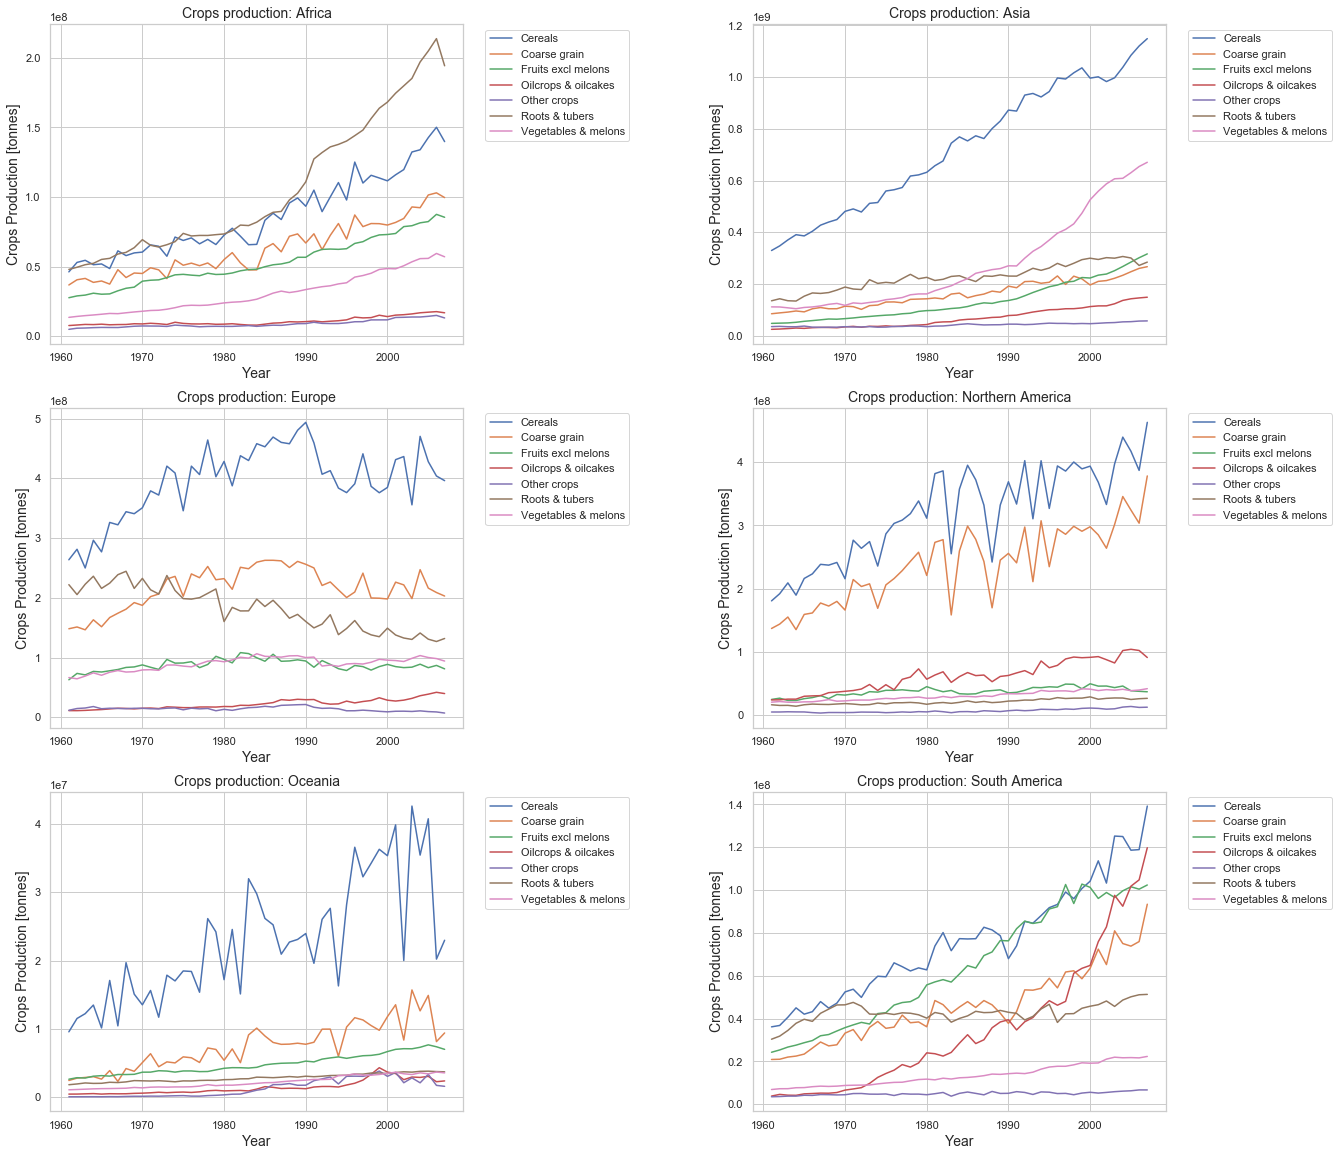

In [12]:
fig = plt.figure(figsize = (20, 20)).subplots_adjust(wspace=0.7)
i = 0

for area in crops_cont.Area.unique():
    i+=1
    plot_compare_areas(crops_no_total[crops_no_total['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Crops Production [tonnes]', title = 'Crops production: '+area,
                    subplot = True, ax = plt.subplot(3, 2, i), outside = True)

**Observations:**
- South America is the only continent that has had a large increase in the crops category 'oilcrops & oilcakes'. This is not surprising as South America are for example harvesting rainforests to extract palm oil.
- Africa and Europe are the only continent that have the crops category 'roots & tubers' in their top three most produced crops in 2007. 
- In 2007 the biggest crops category is 'cereals' as this is in the top two most produced categories for all continents. 
- In 2007 and in warmer continents it is possible to see a larger fruit production (Africa, South America, Oceania).
- Asia is the only continent that has vegetables in the top two most produced in 2007.

### Summary, question 1

**How has the crops and livestock production changed since the 1960s?**

Food production has increased in all continents from 1961 to 2013 and today we are poducing more food per person than we did in 1961. We can also see that the way that the production has developped follows a general pattern, that is, the population growth in each respective continent. This makes sense as an increased population will require more food production in order to be able to feed all habitants. This also lead to the fact that every crop and meat category has increased production wise since 1961. No category has decreased in popularity on world level. However, when looking at the different continents it is possible to see decrease in popularity for some products. For example Europe has had a decrease in roots & tubers production but Africa has had a big increase in production of roots & tubers. Therefore, on a world level, roots & tubers production has increased but it is no longer as popular in Europe. As mentioned, most categories have increased in production, however the smallest crops/meats categories have held a quite consistent production quantity over the years (visible in the box plots). These categories are 'crops, other', 'meat, other' and 'meat, equidae & camelidae'. Asia, Oceania and South America have had a lot larger increase in food production compared to population. And Europe has had a much larger increase in population compared to food production.

The three most produced meat categories are pig, chicken and cattle with pig being the largest one. In fourth place, we have bovidae, since it is big in Oceania (sheep) and Africa (goat & buffalo). All continents but North America and Oceania have a larger increase in meat producation than both crops production and population growth. 

The biggest crops production category is cereals which is not not surprising as this includes rice and wheat. Second and third place are coarse grain and roots & tubers.

## Question 2 - Is there a connection between the development of livestock primary production and crop production?

The purpose of this question is to see if there are any trends in our data, and to answer this we will study both total and normalized data. We will also have to look at

- Are we producing more food per person?
- Has the porportions of meat vs. crops changed in our diet?
- Can we see differences between each continent?

Increase of food production per person:  24.71 %


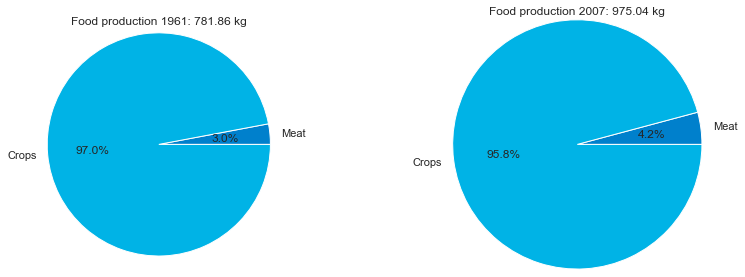

In [13]:
#Year on year growth of meat and crop production
#Average growth of meat production in total per year
mean_meat_prodgrow = (meat_total.groupby('Year').sum().diff() / meat_total.groupby('Year').sum()).Value.mean() * 100

#Average growth of crops production in total per year
mean_crop_prodgrow = (crops_total.groupby('Year').sum().diff() / crops_total.groupby('Year').sum()).Value.mean() * 100

#Average population growth globally per year
mean_pop_growth = (pop_cont.groupby('Year').sum().diff()/pop_cont.groupby('Year').sum()).Value.mean() * 100

#Total food production per person in 1961 and 2007
temp1 = (comparison_m['1961 total [tonnes]'].sum() + comparison_c['1961 total [tonnes]'].sum())\
        / pop_cont[pop_cont.Year == 1961].Value.sum()  
temp2 = (comparison_m['2007 total [tonnes]'].sum() + comparison_c['2007 total [tonnes]'].sum())\
        / pop_cont[pop_cont.Year == 2007].Value.sum()
change = temp2 / temp1 * 100 - 100    

temp_labels = ['Meat', 'Crops']
sizes1961 = [(comparison_m['1961 total [tonnes]'].sum() / population_1961.Value.sum())/temp1,
         (comparison_c['1961 total [tonnes]'].sum() / population_1961.Value.sum())/temp1]
sizes2007 = [(comparison_m['2007 total [tonnes]'].sum() / population_2007.Value.sum())/temp1,
         (comparison_c['2007 total [tonnes]'].sum() / population_2007.Value.sum())/temp1]

fig, ax = plt.subplots(1, 2)

fig.set_size_inches(10,10)
fig.subplots_adjust(wspace = 2, hspace = 5)
pie_rad = 2
area = np.pi * (pie_rad**2)

title1 = 'Food production 1961: ' + str(round(temp1, 2)) + ' kg'
title2 = 'Food production 2007: ' + str(round(temp2, 2)) + ' kg'

ax[0].pie(sizes1961, labels = temp_labels, radius = pie_rad, 
          autopct='%1.1f%%', colors = [[0, 0.5, 0.8], [0, 0.7, 0.9]])
ax[0].set_title(title1, pad = 50)
ax[1].pie(sizes2007, labels = temp_labels, radius = np.sqrt(area*(1+change/100)/np.pi), 
          autopct='%1.1f%%', colors = [[0, 0.5, 0.8], [0, 0.7, 0.9]])
ax[1].set_title(title2, pad = 60)

print('Increase of food production per person: ', round(change, 2), '%')

Globally the food production per person has increased by nearly 25%. At the same time the proportion of meat to crops has change as well, as can be seen in the plot above. In other words, today we produce both more food per person and our diets have become more meat heavy. The increase is very logical as the world has become richer (GDP per capita has steadily increased https://data.worldbank.org/indicator/NY.GDP.PCAP.KD), we produce more food and less people are starving. 

In [14]:
comparison_m.sort_values(by = 'Area', inplace = True)
comparison_c.sort_values(by = 'Area', inplace = True)

pop_cont1961 = population_1961.drop('Area Code', axis = 1).sort_values(by = 'Area').reset_index()
pop_cont2007 = population_2007.drop('Area Code', axis = 1).sort_values(by = 'Area').reset_index()

product_pers = pd.DataFrame({'Area':comparison_m.Area,
                             'Meat per person 1961 (kg)' : comparison_m['1961 total [tonnes]'].values / pop_cont1961.Value,
                             'Meat per person 2007 (kg)' : comparison_m['2007 total [tonnes]'].values / pop_cont2007.Value,
                             'Crops per person 1961 (kg)' : comparison_c['1961 total [tonnes]'].values / pop_cont1961.Value,
                             'Crops per person 2007 (kg)' : comparison_c['2007 total [tonnes]'].values / pop_cont2007.Value})
product_pers['% Increase meat'] = round(product_pers['Meat per person 2007 (kg)']
                                        / product_pers['Meat per person 1961 (kg)'] * 100 - 100,2)
product_pers['% Increase crops'] = round(product_pers['Crops per person 2007 (kg)']
                                         / product_pers['Crops per person 1961 (kg)'] * 100 - 100,2)

product_pers

,Area,Meat per person 1961 (kg),Meat per person 2007 (kg),Crops per person 1961 (kg),Crops per person 2007 (kg),% Increase meat,% Increase crops
0,Africa,13.474699,15.263559,637.920628,629.614385,13.28,-1.30
1,Asia,5.308351,26.642202,451.125715,710.862655,401.89,57.58
2,Europe,46.395296,73.587627,1215.135412,1301.835252,58.61,7.13
3,Northern America,86.547058,138.026550,1952.933606,3143.525706,59.48,60.96
4,Oceania,140.544138,174.310982,1102.921385,1449.491258,24.03,31.42
5,South America,42.669172,92.514345,825.775312,1407.529798,116.82,70.45


In the table above we can see that all continents have seen an increase in production of meat per person, with Asia experiencing the largest increase and Africa the smallest. Europe and Northern America have seen a similar increase, however it is worth noting that the procuction of meat was higher to begin with in Northern America. There are 2 distinct groups in meat production quantities, Asia & Africa and the rest. In growth however Asia is in a league of its own. Overall production is clearly highest per capita in Oceania.

When looking at at the crops production we can see that groups are again quite distinct with Africa and Asia producing the least and while the rest produce much more food per person. Interestingly the production of crops per capita has in fact decreased in Africa while all other continents have experienced growth. 

In [15]:
#Correlation between yearly lgarithmic increase in global meat and crop production 
pd.DataFrame({'Meat':np.log(meat_cont[meat_cont['Item'] == 'Meat, Total'].groupby('Year').sum().Value).diff().dropna(),
               'Crops':np.log(crops_cont[crops_cont['Item'] == 'Crops, total'].groupby('Year').sum().Value).diff().dropna()}).corr()

,Meat,Crops
Meat,1.000000,-0.324508
Crops,-0.324508,1.000000


When looking at the correlation between the growth of crop and meat production, we can see that they are negatively correlated. In other words, we can see that when meat production increases crops production decreases globally. However, the correlation is not very strong at -0.32, and correlation does not equal causation, and thus increases in meat production do not necessarily cause a decrease in crop production.

In [16]:
crops_cont[crops_cont['Item'] == 'Crops, total']

tmp = meat_no_total.groupby(['Year', 'Item']).agg({'Value':'sum'}).reset_index().sort_values(by=['Year', 'Item'], ascending=True)
meat_world = pd.DataFrame(columns=meat_no_total.Item.sort_values().unique(), 
             index=tmp.Year.unique(),
             data=tmp.Value.values.reshape(len(tmp.Year.unique()),len(meat_no_total.Item.unique())))

tmp = meat_cont[meat_cont['Item'] == 'Meat, Total'][{'Area', 'Year', 'Value'}].sort_values(by='Year')
meat_continentally = pd.DataFrame(columns=meat_cont.Area.sort_values().unique(), 
                                  index=tmp.Year.unique(),
                                  data=tmp.Value.values.reshape(len(tmp.Year.unique()), len(meat_cont.Area.unique())))

tmp = crops_cont[crops_cont['Item'] == 'Crops, total'][{'Area', 'Year', 'Value'}].sort_values(by='Year')
crops_continentally = pd.DataFrame(columns=crops_cont.Area.sort_values().unique(), 
                                  index=tmp.Year.unique(),
                                  data=tmp.Value.values.reshape(len(tmp.Year.unique()), len(crops_cont.Area.unique())))

cont_correlation = pd.DataFrame(columns = ['Correlation'], index=meat_cont.Area.unique(), data=[0]*6)
for continent in meat_cont.Area.unique():
    cont_correlation.loc[continent] = (pd.DataFrame({'Meat':np.log(meat_continentally[continent]).diff().dropna(),
                                                    'Crops':np.log(crops_continentally[continent]).diff().dropna()}).corr().iloc[0,1])
cont_correlation

,Correlation
Africa,-0.016561
Asia,-0.195210
Europe,-0.247197
Northern America,-0.310801
Oceania,-0.214122
South America,-0.087757


When looking at the correlation of crop and meat production growth continentally, we can see that compared to global change, the changes are much less correlated, except for Northern America. In other words, within continents there does not seem to be a link between meat and crop production.

## Question 3 - How are the differences in production quantities between the different continents?

The purpose of this question is to study the difference in production at a continent-level. For example, it can be interesting to see the difference between developed continents, like Europe and North-America, and continents like Africa and Asia.

- Study food production in general, and with a crops vs. meat analysis.
- What can be said about the normalized production?
- Can we say if any continents are producing more than it needs?
- Try to find data on how much food a person needs per year.
    - This is pretty hard because of energy/tonne

## Question 4 - How has the development in agriculture affected emission of greenhouse gasses?

This question is about the consequences of what we have studied in the previous questions.

- Can we find evidence that higher meat consumption leads to higher emissions?
- Is it better for the environment to eat crops rather than livestock?
- Are there any particular meat or crop that affect the CO2 emissions more/less than the average?

****Preparing the data****

In order to study the agricultural production and the emissions we need the 3 datasets to match when it comes to time and categories. All three datasets will therefor by limited to a certain timeframe and the categories that are missing from the emission dataset will be removed from the crop and meat datasets.

In [14]:
# Load data from emissions dataset
emi_data = pd.read_pickle(data_path + 'continent_categorized_emissions.pkl')
# Restructure datasets
emission_data = emi_data.groupby(['Area','Year','Item']).agg({'Value':'sum', 'Element':'first', 'Unit':'first'}).reset_index()

print(emission_data.Item.unique())
print(crops_cont.Item.unique())

['Cereals excluding rice' 'Meat, buffalo' 'Meat, cattle' 'Meat, chicken'
 'Meat, goat' 'Meat, pig' 'Meat, sheep' 'Rice, paddy']
['Oilcrops & oilcakes' 'Fruits excl melons' 'Vegetables & melons'
 'Roots & tubers' 'Cereals' 'Coarse grain' 'Other crops' 'Crops, total']


As for the crops dataset, the only category that we have emission data on is _Cereals excluding rice_ and _Rice, paddy_ which corresponds with _Cereals_ in the crops dataset, as is shown above. Therefore, all items apart from _Cereals_ are removed. 

In [15]:
# Keep only crop data that we have emission data on
crop_relevant = crops_cont[crops_cont.Item == 'Cereals']

print(emission_data.Item.unique())
print(meat_cont.Item.unique())

['Cereals excluding rice' 'Meat, buffalo' 'Meat, cattle' 'Meat, chicken'
 'Meat, goat' 'Meat, pig' 'Meat, sheep' 'Rice, paddy']
['Meat, equidae and camelidae' 'Meat, bovidae' 'Meat, bird excl chicken'
 'Meat, other' 'Meat, Total' 'Meat, cattle' 'Meat, chicken' 'Meat, pig']


The same will be done with the meat dataset, all of the items that aren't present in the emission dataset will be removed.

We also only keep the years that all of the datasets have data from.

In [16]:
# Keep only meat data that we have emission data on
meat_relevant = meat_cont[meat_cont.Item.isin(emission_data.Item.unique())]

# Find years in which we have data from all three datasets
starting_year = max(meat_relevant.Year.min(), crop_relevant.Year.min(), emission_data.Year.min())
ending_year = int(min(meat_relevant.Year.max(), crop_relevant.Year.max(), emission_data.Year.max()))

# Remove all the other years
meat_relevant = meat_relevant[(meat_relevant.Year >= starting_year) & (meat_relevant.Year <= ending_year)]
crop_relevant = crop_relevant[(crop_relevant.Year >= starting_year) & (crop_relevant.Year <= ending_year)]
emission_data = emission_data[(emission_data.Year >= starting_year) & (emission_data.Year <= ending_year)]
print('In this question we will study data from {0} to {1}.'.format(starting_year, ending_year))

In this question we will study data from 1961 to 2007.


****Studying the data****

In order to answer questions about developments in agriculture and it's impact on emissions it is of interest to look att how the productions and emissions has increased during the years 1961 to 2007.

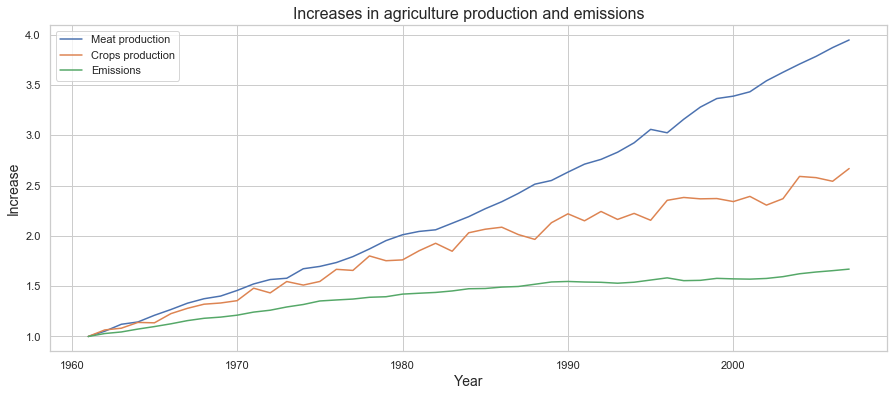

Meat production has increased 294% since 1961 
Crop production has increased 166% since 1961 
Emissions from agriculture have increased 66% since 1961


In [17]:
meat_yearly = meat_relevant.groupby('Year').agg({'Value':'sum'})
crop_yearly = crop_relevant.groupby('Year').agg({'Value':'sum'})
emission_yearly = emission_data.groupby('Year').agg({'Value':'sum'})

plt.figure(figsize = (15,6))
plt.plot(meat_yearly.Value / meat_yearly.Value.array[0])
plt.plot(crop_yearly.Value / crop_yearly.Value.array[0])
plt.plot(emission_yearly.Value / emission_yearly.Value.array[0])
plt.xlabel('Year', fontsize=14)
plt.ylabel('Increase', fontsize=14)
plt.title('Increases in agriculture production and emissions', fontsize=16)
plt.legend(['Meat production', 'Crops production', 'Emissions'])
plt.show()
print(\
'Meat production has increased {0}% since 1961 \n\
Crop production has increased {1}% since 1961 \n\
Emissions from agriculture have increased {2}% since 1961'.format(
                        int(meat_yearly.Value.array[-1] / meat_yearly.Value.array[0] * 100) - 100,
                        int(crop_yearly.Value.array[-1] / crop_yearly.Value.array[0] * 100) - 100,
                        int(emission_yearly.Value.array[-1] / emission_yearly.Value.array[0] * 100) - 100))

From the plot above we can see that the production of both meat and crops as well as the emissions have increased since 1961. It is also worth noting that emission hasn't seen the same growth and meat has grown quite a lot more than crops. Now, it seems weird that emissions hasn't seen the same increase as crop and meat combined, this might be due to higher efficency in both meat and crop production leading to less emissions per produced tonne of chosen agriculture product. Let's examine!

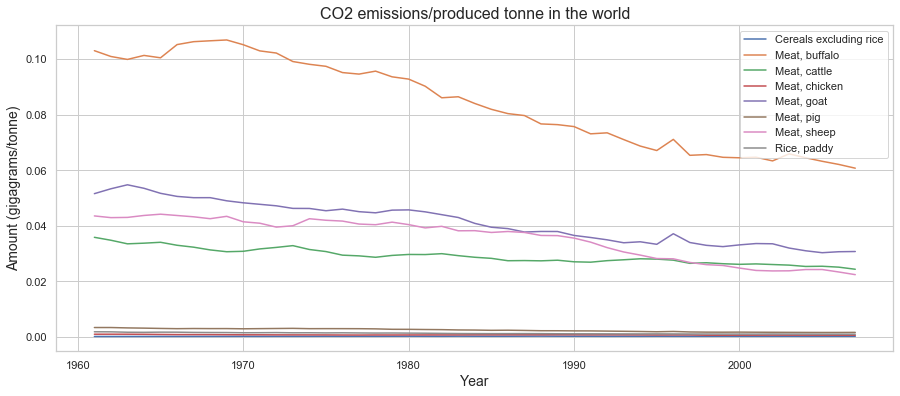

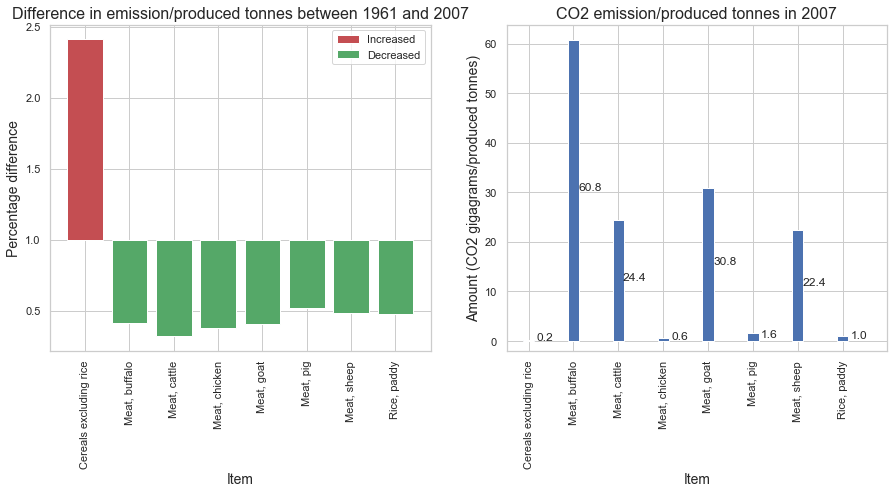

In [23]:
world_categorized_emissions = emission_data.groupby(['Item', 'Year']).agg({'Value':'sum'}).reset_index()
world_categorized_production = pd.read_pickle(data_path + 'world_categorized_production.pkl')
world_categorized_production = world_categorized_production[world_categorized_production.Year <= 2007]

plt.figure(figsize = (15,6))

items = world_categorized_emissions.Item.unique()
efficency_diff = []
co2_tonnes = []

for item in items:
    years = world_categorized_emissions[world_categorized_emissions['Item'] == item].Year.values
    item_emissions = world_categorized_emissions[world_categorized_emissions['Item'] == item].Value.values
    item_production = world_categorized_production[world_categorized_production['Item'] == item].Value.values
    plt.plot(years, item_emissions/item_production)
    
    eff_1961 = item_emissions[0]/item_production[0]
    eff_2007 = item_emissions[-1]/item_production[-1]
    diff = eff_2007/eff_1961
    efficency_diff.append(diff if diff >= 1 else -diff)
    
    co2_tonnes.append(1000 * item_emissions[-1]/item_production[-1])
    
plt.legend(world_categorized_emissions.Item.unique())
plt.title('CO2 emissions/produced tonne in the world', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount (gigagrams/tonne)', fontsize=14)
plt.show()

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
ax = plt.bar(x=items, height=efficency_diff, bottom=1, color= ['r' if eff > 1 else 'g' for eff in efficency_diff])
plt.xticks(rotation = 90)
plt.title('Difference in emission/produced tonnes between 1961 and 2007', fontsize=16)
plt.xlabel('Item', fontsize=14)
plt.ylabel('Percentage difference', fontsize=14)
plt.legend((ax[0], ax[1]), ('Increased', 'Decreased'))

plt.subplot(1,2,2)
width = 0.25
margin = 0.0025
p1 = plt.bar(x=np.arange(len(items)), height=co2_tonnes, width=width)
plt.xticks(rotation = 90)
plt.title('CO2 emission/produced tonnes in 2007', fontsize=16)
plt.xlabel('Item', fontsize=14)
plt.ylabel('Amount (CO2 gigagrams/produced tonnes)', fontsize=14)
autolabel_q4(p1, co2_tonnes)
plt.xticks(np.arange(len(items)), items)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([-2,ymax])
plt.xlim([xmin,xmax+0.5])
plt.show()

As we assumed, most of the items are produced more efficently in 2007 as opposed to 1961 apart from _Cereals, excluding rice_. What is also interesting is the difference in CO2 emission per produced tonne for the various items. We can see that _Meat, buffalo_, _Meat, cattle_, _Meat, goat_ and _Meat, sheep_ produces a lot more CO2 during production compared to _Meat, chicken_, _Meat,  pig_, _Cereals, excluding rice_ and _Rice, paddy_.

In order to compare the emissions per tonnes of produced item it is necessary to take the energy in each food into consideration. For example, if cattle meat has 25 times the amount of energy in its food compared with rice we can not say that meat cattle is worse to produce than rice, even though the plot above indicates that. We could also discuss further and compare proteins/fats/carbohydrates in each item, however, we will only compare the energy in terms of calories for each item to try and get a better view of different food's impact on the greenhouse gasses.

Here we will have to make some assumptions. The energy data will be taken from the [USDA](https://fdc.nal.usda.gov/index.html) database. However, we could not find data on energy/tonnes of a whole animal but will instead look at _Beef, ground, 85% lean meat / 15% fat, patty, cooked, broiled_ when determining the energy level of _Meat, cattle_ and so on. 



In [19]:
# Data from USDA, Kcal per 100g
# Order is in the same way as items are in the plots above
kcalories = [378.0, 109.0, 250.5, 239.0, 143.2, 242.1, 294.0, 130.0] 
# Scale to: Kcal per tonnes
kcalories_tonnes = np.asarray(kcalories) * 10000

item_energy = pd.Series(kcalories_tonnes, items)
item_energy

Cereals excluding rice    3780000.0
Meat, buffalo             1090000.0
Meat, cattle              2505000.0
Meat, chicken             2390000.0
Meat, goat                1432000.0
Meat, pig                 2421000.0
Meat, sheep               2940000.0
Rice, paddy               1300000.0
dtype: float64

Now that we have the amount of energy per tonnes of item, let's scale the previous values in the _CO2 emission/produced tonnes in 2007_ plot with each items energy.

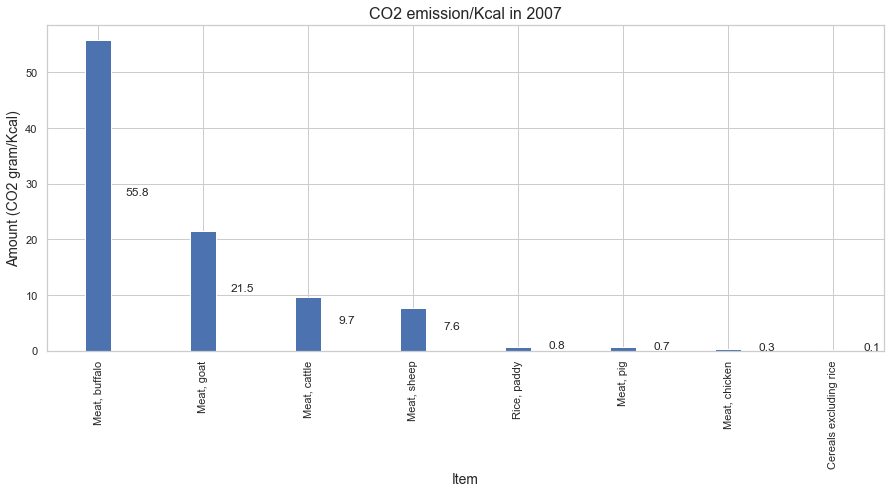

In [20]:
# Scale to: CO2 gram emitted per kcal
gram_emission_kcal = (co2_tonnes/kcalories_tonnes) * 1e6
item_kcal_emission = pd.Series(gram_emission_kcal, items).sort_values(ascending=False)

plt.figure(figsize = (15,6))
p1 = plt.bar(x=item_kcal_emission.index, height=item_kcal_emission, width=width)
autolabel_q4(p1, item_kcal_emission)
plt.xticks(rotation = 90)
plt.title('CO2 emission/Kcal in 2007', fontsize=16)
plt.xlabel('Item', fontsize=14)
plt.ylabel('Amount (CO2 gram/Kcal)', fontsize=14)
plt.show()

When observing the plot above it is very important to keep in mind that the Kcal/100g for all of the different animals are too high. This is becuase all of the bones/skin etc that will not be eaten have not been taken into consideration. This means that all of the meat item's _CO2 gram/Kcal_ should be a bit higher. This is not the case with _Rice, paddy_ and _Cereals, excluding rice_ since all of what is produced can be consumed.

Now, we can still see that most of the meats emit way more CO2 per Kcal than the crops. Especially _Meat, buffalo_ emits a lot of CO2 per Kcal compared to the other items. We can also see that _Meat, chicken_ and _Meat, pig_ seem to emit less that _Rice, paddy_. However, we can not draw any conclusions as to wheter _Rice, paddy_ is worse than the meats mentioned because of our calculations. But, we can say that if one were to eat meat, pig and chicken are way better alternatives than meat from sheep, cattle, goat or buffalo. 

****Conclusions question 4****

- Meat and crop production has increased which has led to higher emissions.
- Most of the meat and crop production has become more effective which has lowered the emission per produced tonnes.
- The meat categories buffalo, cattle, goat and pig emit much more than the crops studied in this question and it is therefore better for the environment to eat crops rather than eating meat from these categories.
- Meat from pig and chicken are much better to eat compared to sheep, cattle, goat and buffalo as they seem to emit close to what cereals and rice emit.